##**Architecture Diagram of the Approach**

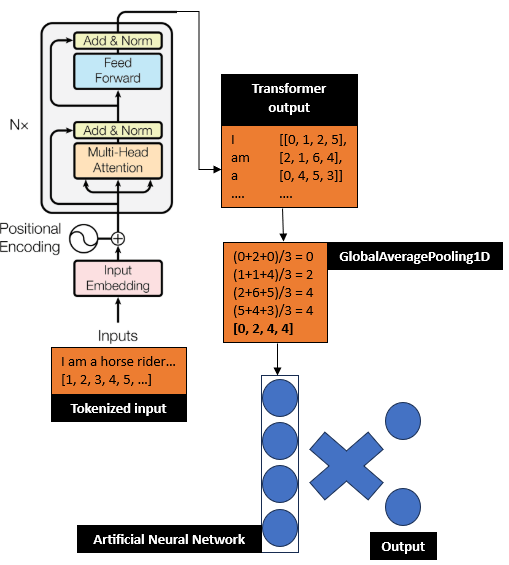

##**Cleaning and preprocessing input data**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

dataset = pd.read_csv('IMDB Dataset.csv')

X = []
total_words = 0
vocabulary = {}
for i in dataset['review']:
  encoded_list = []
  for j in i.split():
    j = j.lower()
    if j not in vocabulary:
      vocabulary[j] = total_words
      total_words += 1
    encoded_list.append(vocabulary[j])
  X.append(encoded_list)

Y = []
output_cat = {'positive': 1, 'negative': 0}
for i in dataset['sentiment']:
  Y.append(output_cat[i])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y , random_state=104, test_size=0.5, shuffle=True)
max_len = max([len(i) for i in X])

# Padding and making all strings of equal length is important before numpy array conversion, else,
# will get dimensionality error since, all sentences are of different length
X_train = tf.keras.utils.pad_sequences(X_train, maxlen=max_len)
X_train = np.array(X_train)

# Padding and making all strings of equal length is important before numpy array conversion, else,
# will get dimensionality error since, all sentences are of different length
X_test = tf.keras.utils.pad_sequences(X_test, maxlen=max_len)
X_test = np.array(X_test)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train, Y_train

##**Transformer Architecture**

In [ ]:
# Check the Transformer's architecture diagram above to understand the flow of the function below

def TransformerBlock(inputs, embed_dim, num_heads, hidden_layer_dim, rate=0.1):
  # Multihead Attention layer
  attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
  attn_output = tf.keras.layers.Dropout(rate)(attn_output)

  # Add and Normalization layer
  add = inputs + attn_output
  norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add)

  # Feed Forward layer
  feedFwdNet = tf.keras.Sequential([
      tf.keras.layers.Dense(hidden_layer_dim, activation="relu"),
      tf.keras.layers.Dense(embed_dim),
    ])
  ffn_output = feedFwdNet(norm)
  ffn_output = tf.keras.layers.Dropout(rate)(ffn_output)

  # Add and Normalization layer
  add = norm + ffn_output
  return tf.keras.layers.LayerNormalization(epsilon=1e-6)(add)

##**Embedding definition**

In [ ]:
'''
The final input to a transformer model is obtained by adding the token embeddings and the positional embeddings element-wise. This addition provides the model with both:
  What: The semantic meaning of tokens (via token embeddings).
  Where: The position of tokens in the sequence (via positional embeddings).

Example:
Consider the sentence "I love NLP":
  Token Embeddings:
  [[0.1,0.3,0.4],[0.2,0.6,0.5],[0.7,0.9,0.8]]

  Positional Embeddings:
  [[0.01,0.02,0.03],[0.04,0.05,0.06],[0.07,0.08,0.09]]

  Final Input Embeddings:
  [[0.11,0.32,0.43],[0.24,0.65,0.56],[0.77,0.98,0.89]]
'''
# Check the Transformer's architecture diagram above to understand the flow of the function below

def TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, x):
  # Positional embedding/encoding
  pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
  maxlen = x.shape[-1]
  positions = np.arange(0, maxlen, step=1)
  positions = pos_emb(positions)

  # Token/Input embedding
  token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
  x = token_emb(x)

  # Final Input embedding (summation of Token & Positional embedding) [as mentioned in the Architecture diagram above]
  return x + positions

##**Creating the Model**

In [ ]:
embed_dim = 32            # Embedding size for each token
num_heads = 2             # Number of attention heads
ff_dim = 32               # Hidden layer size in feed forward network inside transformer
maxlen = max_len          # Maximum length String in the column "dataset['reviews']"
vocab_size = total_words  # Total no. of words in the whole dataset

# Make use of Transformer Architecture to understand the text
inputs = tf.keras.layers.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, inputs)
x = TransformerBlock(x, embed_dim, num_heads, ff_dim)


# Rest of the Architecture for predicting the output
x = tf.keras.layers.GlobalAveragePooling1D()(x) # Learn more on this: https://stackoverflow.com/questions/75067335/what-does-globalaveragepooling1d-do-in-keras
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

##**Training the model**

In [ ]:
history = model.fit(
    X_train, Y_train, batch_size=32, epochs=2, validation_data=(X_test, Y_test)
)

##**Testing the Model**

In [ ]:
TestText = "Very good movie. Best I had watched."
output_cat = {0: 'negative', 1:'positive'} # Since, in the beginning we did ==> "output_cat = {'positive': 1, 'negative': 0}"

x = [vocabulary[i] if i in vocabulary else 0 for i in TestText.split()]
x = tf.keras.utils.pad_sequences([x], maxlen=max_len)

prediction = model.predict(x)
print("Probabilities:", prediction)
print(output_cat[np.argmax(prediction)])